In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import seaborn as sns
from sklearn import decomposition, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from scipy import stats

from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import cluster, metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
billets = pd.read_csv ("billets.csv", sep= ";")
billets_production = pd.read_csv("billets_production.csv")

## <a name="C2">I - Import des datasets, nettoyage et analyse des données

In [3]:
#Visualisation des 5 premieres lignes
billets.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### <a name="C2">Dimensions géométriques
(toutes les mesures en mm) :
  - length = longueur du billet,
  - height_left = hauteur du billet (mesurée sur le côté gauche),
  - height_right = hauteur du billet (mesurée sur le côté droit),
  - margin_up = marge entre le bord supérieur du billet et l'image,
  - margin_low = marge entre le bordd inférieur du billet et l'image,
  - diagonal = diagonale du billet.

In [4]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Text(0.5, 1.0, 'Répartition des vrais et faux billets')

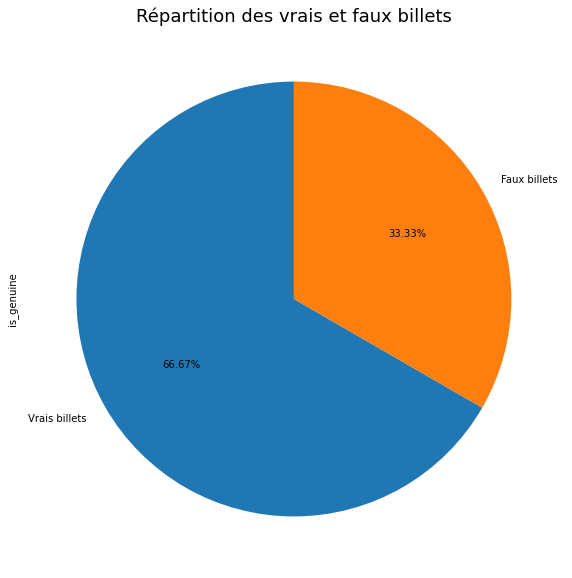

In [5]:
# Graphique de la répartition des billets
plt.figure(figsize=(16,10))
billets['is_genuine'].value_counts().plot(kind="pie",autopct='%1.2f%%', 
                                               labels=["Vrais billets","Faux billets"],startangle=90)
plt.title("Répartition des vrais et faux billets", fontsize=18)


In [6]:
billets['is_genuine'].unique()

array([ True, False])

In [7]:
#37 données manquantes dans la colonne "margin_low"
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [8]:
#Ci-dessous les 37 lignes qui ont des données manquantes
billets.index[billets.isnull().any(axis=1)]

Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')

## <a name="C3">II - Régression lineaire multiple

In [9]:
dt = billets.copy()

In [10]:
dt.drop(["is_genuine"], inplace=True, axis=1)

In [11]:
#Séparation des données des données manquantes
billets_regression_lineaire_training = dt.dropna()
billets_regression_lineaire_test = dt[dt.isnull().any(axis=1)]

#Création de X_train et Y_train
X_train = billets_regression_lineaire_training.drop("margin_low", axis=1)
Y_train = billets_regression_lineaire_training["margin_low"]

#Régression linéaire
regression_lineaire = LinearRegression()
model_regression_lineaire = regression_lineaire.fit(X_train, Y_train)

#Prédiction
X_train = billets_regression_lineaire_training[["diagonal","height_left","height_right", "margin_up", "length"]]
billets_regression_lineaire_training["margin_low_pred"] = regression_lineaire.predict(X_train)

C:\Users\louna.chrisostome\AppData\Local\Temp\ipykernel_23400\1683618199.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_regression_lineaire_training["margin_low_pred"] = regression_lineaire.predict(X_train)


In [12]:
print("Intercept:", model_regression_lineaire.intercept_)
print("Coéfficients:", model_regression_lineaire.coef_)

Intercept: 22.994842714447913
Coéfficients: [-0.11105978  0.18412242  0.25713805  0.2561879  -0.40910293]


In [13]:
#Instanciation
verifr_regression_lineaire = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", data = billets)
# Calculs:
res_lin = verifr_regression_lineaire.fit()
print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          4.75e-299
Time:                        00:19:37   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

Le R carré, également appelé coefficient de détermination, est une mesure de la qualité de l'ajustement d'un modèle de régression aux données. Il indique à quel point les valeurs prédites du modèle correspondent aux valeurs observées des données. Le R carré varie entre 0 et 1, où 0 indique qu'aucune variation dans la variable dépendante ne peut être expliquée par le modèle, et 1 indique que la totalité de la variation peut être expliquée par le modèle. Plus la valeur de R carré est proche de 1,
La régression logistique est une technique de modélisation statistique utilisée pour prédire des variables binaires, c'est-à-dire des variables qui prennent deux valeurs possibles, comme "oui" ou "non", "vrai" ou "faux", "1" ou "0". Elle est utilisée pour prédire la probabilité d'un événement binaire en fonction des variables prédictives.

## <a name="C3">III - Testons l'hypothèses par analyse des résidus

C:\Users\louna.chrisostome\AppData\Local\Temp\ipykernel_23400\3633197200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_regression_lineaire_training["residual"] = billets_regression_lineaire_training["margin_low"] - billets_regression_lineaire_training["margin_low_pred"]


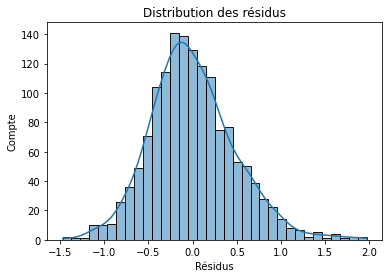

In [14]:
#Création d'une colonne contenant les residus
billets_regression_lineaire_training["residual"] = billets_regression_lineaire_training["margin_low"] - billets_regression_lineaire_training["margin_low_pred"]

#Graphique
sns.histplot(billets_regression_lineaire_training["residual"], kde=True)
plt.xlabel("Résidus")
plt.ylabel("Compte")
plt.title("Distribution des résidus")
plt.show()

In [15]:
#Test de normalité d'Aderson-Darling
print("La p-value du test d'Aderson-Darling est de", normal_ad(billets_regression_lineaire_training["residual"])[1])

La p-value du test d'Aderson-Darling est de 5.114137678791534e-12


## <a name="C3"> Homoscédasticité 

{'Test Statistic': 185.44024760393418, 'p-value': 5.215881959229449e-26, 'F-Statistic': 8.016852051186403, 'F-Test p-value': 4.616518789895696e-28}


Text(0.5, 1.0, 'Homoscédasticité')

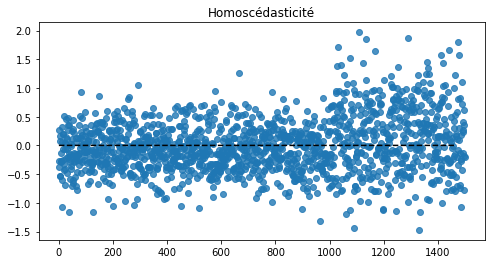

In [16]:
white_test = het_white(res_lin.resid, res_lin.model.exog)
labels_white_test = ["Test Statistic", "p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_test, white_test)))

#Graphique
plt.subplots(figsize=(8, 4))
plt.scatter(x=billets_regression_lineaire_training.index, y=billets_regression_lineaire_training["residual"], alpha=0.8)
plt.plot(np.repeat(0, len(billets_regression_lineaire_training.index)+2), color="black", linestyle='--')
plt.title("Homoscédasticité")

## <a name="C3"> Colinéarité des variables

In [17]:
#Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables 
variables = res_lin.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[4.725732131263034,
 1.02819949790807,
 1.1737111515376197,
 1.3208356332473368,
 1.5960903251807717,
 3.6132551150015373]

## <a name="C3">IV - Identification des individus vs individus atypiques et influents

C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Résidus studentisés')

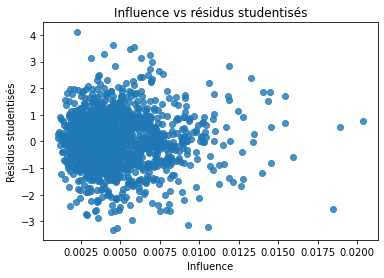

In [18]:
#Identification des individus atypiques et influents (iai)
student_resid = res_lin.get_influence().resid_studentized_external
(cooks, p_val_cooks) = res_lin.get_influence().cooks_distance
(dffits, p_val_dffits) = res_lin.get_influence().dffits
leverage = res_lin.get_influence().hat_matrix_diag

#Graphique
sns.regplot(leverage, res_lin.resid_pearson, fit_reg=False)
plt.title("Influence vs résidus studentisés")
plt.xlabel("Influence")
plt.ylabel("Résidus studentisés")



In [19]:
#Création d'un dataset pour la visualisation
billets_indiv_atypique_influent = pd.concat([billets_regression_lineaire_training["margin_low"], res_lin.get_influence().summary_frame()], axis = 1)
billets_indiv_atypique_influent = billets_indiv_atypique_influent.rename(columns={"hat_diag": "leverage"}) 
billets_indiv_atypique_influent.round(3).head()


,margin_low,dfb_Intercept,dfb_is_genuine[T.True],dfb_diagonal,dfb_height_left,dfb_height_right,dfb_margin_up,dfb_length,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,4.52,-0.046,0.047,-0.021,0.062,0.078,-0.020,-0.019,0.002,0.759,0.020,0.109,0.759,0.109
1,3.77,-0.052,-0.002,0.035,0.044,0.007,0.006,0.006,0.001,-0.843,0.006,-0.066,-0.843,-0.066
2,4.40,-0.032,-0.001,0.038,0.031,-0.022,-0.012,-0.000,0.000,0.640,0.008,0.059,0.639,0.058
3,3.62,-0.036,-0.003,0.068,0.001,-0.018,0.006,-0.020,0.001,-1.252,0.004,-0.084,-1.253,-0.084
4,4.04,0.001,0.001,-0.001,0.001,-0.001,0.001,-0.001,0.000,0.022,0.009,0.002,0.022,0.002


In [20]:
#Studentisation des residus
std_res = billets_indiv_atypique_influent.student_resid
print ("résidus studentisés:\n", std_res.describe().round(2))

résidus studentisés:
 count    1463.00
mean        0.00
std         1.00
min        -3.34
25%        -0.63
50%        -0.02
75%         0.62
max         4.13
Name: student_resid, dtype: float64


In [21]:
#Individus atypiques
outlier = pd.DataFrame((billets_indiv_atypique_influent["margin_low"][abs(std_res) > 2]))
print(outlier.count())

margin_low    78
dtype: int64


In [22]:
#Identification des individus a forte influence
k_reg_lin = 5
n_reg_lin = 1500 
lev_thr = ((2*k_reg_lin)+2)/n_reg_lin 

print(billets_indiv_atypique_influent["leverage"].describe().round(3))

hg_leverage = billets_indiv_atypique_influent["margin_low"][abs(billets_indiv_atypique_influent["leverage"]) > lev_thr]
print("nombre d'individus à forte influence:", hg_leverage.count())

count    1463.000
mean        0.005
std         0.002
min         0.001
25%         0.003
50%         0.004
75%         0.006
max         0.020
Name: leverage, dtype: float64
nombre d'individus à forte influence: 133


In [23]:
#Identification des individus atypiques a forte influence
outliers_hg_lev =pd.merge(outlier,hg_leverage, left_index=True, right_index=True)
print(outliers_hg_lev.count())
print(outliers_hg_lev)

margin_low_x    10
margin_low_y    10
dtype: int64
      margin_low_x  margin_low_y
1024          4.24          4.24
1029          6.01          6.01
1074          4.36          4.36
1089          3.86          3.86
1122          4.15          4.15
1134          6.34          6.34
1223          4.20          4.20
1329          3.82          3.82
1412          4.14          4.14
1478          6.08          6.08


In [24]:
#Suppression des individus atypique influents
billets_wihtout_indiv_atypique_influent = billets.drop(outliers_hg_lev.index)

#Instanciation
regr_line = smf.ols("margin_low ~ diagonal + height_left + height_right + margin_up + length + is_genuine", data = billets_wihtout_indiv_atypique_influent)

#Calculs
model_regr_line = regr_line.fit()
print(model_regr_line.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     408.7
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          4.38e-307
Time:                        00:19:42   Log-Likelihood:                -739.56
No. Observations:                1453   AIC:                             1493.
Df Residuals:                    1446   BIC:                             1530.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8646      8

## <a name="C3">V - Application du modèle

In [25]:
#Test du modele sur les données
X_test = billets_regression_lineaire_test[["diagonal","height_left","height_right", "margin_up","length"]]
billets_regression_lineaire_test["margin_low_pred"] = regression_lineaire.predict(X_test)

# Concatenons le 
billets_regression_lineaire_resultat = [billets_regression_lineaire_test, billets_regression_lineaire_training]
dt = pd.concat(billets_regression_lineaire_resultat)
dt = dt.drop(["margin_low"], axis=1)
dt.head()

C:\Users\louna.chrisostome\AppData\Local\Temp\ipykernel_23400\2950034111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  billets_regression_lineaire_test["margin_low_pred"] = regression_lineaire.predict(X_test)


,diagonal,height_left,height_right,margin_up,length,margin_low_pred,residual
72,171.94,103.89,103.45,3.25,112.79,4.318525,NaN
99,171.93,104.07,104.18,3.14,113.08,4.393668,NaN
151,172.07,103.80,104.38,3.02,112.93,4.410457,NaN
197,171.45,103.66,103.80,3.62,113.27,4.319014,NaN
241,171.83,104.14,104.06,3.02,112.36,4.650617,NaN


In [26]:
dt.isnull().sum()

diagonal            0
height_left         0
height_right        0
margin_up           0
length              0
margin_low_pred     0
residual           37
dtype: int64

In [27]:
# Détection des doublons
billets.loc[billets[['is_genuine','diagonal','height_left','height_right','margin_low','margin_up','length']]
               .duplicated(keep=False),:]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


In [28]:
billets["margin_low_pred"] = dt["margin_low_pred"]

In [29]:
billets.drop(["margin_low"], inplace = True, axis=1)

In [30]:
billets.rename(columns = {'margin_low_pred': 'margin_low'}, inplace = True)

In [31]:
billets = billets.reindex(columns=['is_genuine', 'diagonal', 'height_left',"height_right","margin_low","margin_up","length"])


In [32]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.788676,2.89,112.83
1,True,171.46,103.36,103.66,4.138908,2.99,113.09
2,True,172.69,104.48,103.50,4.125933,2.94,113.16
3,True,171.36,103.91,103.94,4.156580,3.01,113.51
4,True,171.73,104.28,103.46,4.577425,3.48,112.54


## <a name="C3"> VI - Analyse descriptive

In [33]:
billets['is_genuine'].value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

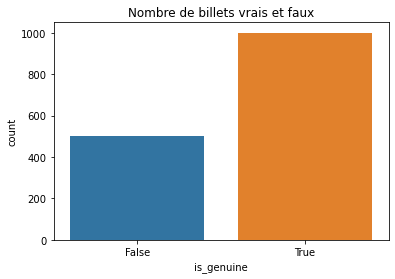

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(data=billets, x='is_genuine')
plt.title('Nombre de billets vrais et faux')
plt.show()
# a enleve

In [37]:
#Répartition des vrais x faux billets
print(billets.groupby(["is_genuine"]).count())

            diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
False            500          500           500         500        500     500
True            1000         1000          1000        1000       1000    1000


In [38]:
#Billets moyens selon l'authenticitee
print(billets.groupby(["is_genuine"]).mean())

             diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                
False       171.90116    104.19034     104.14362    5.056451    3.35016   
True        171.98708    103.94913     103.80865    4.196987    3.05213   

               length  
is_genuine             
False       111.63064  
True        113.20243  


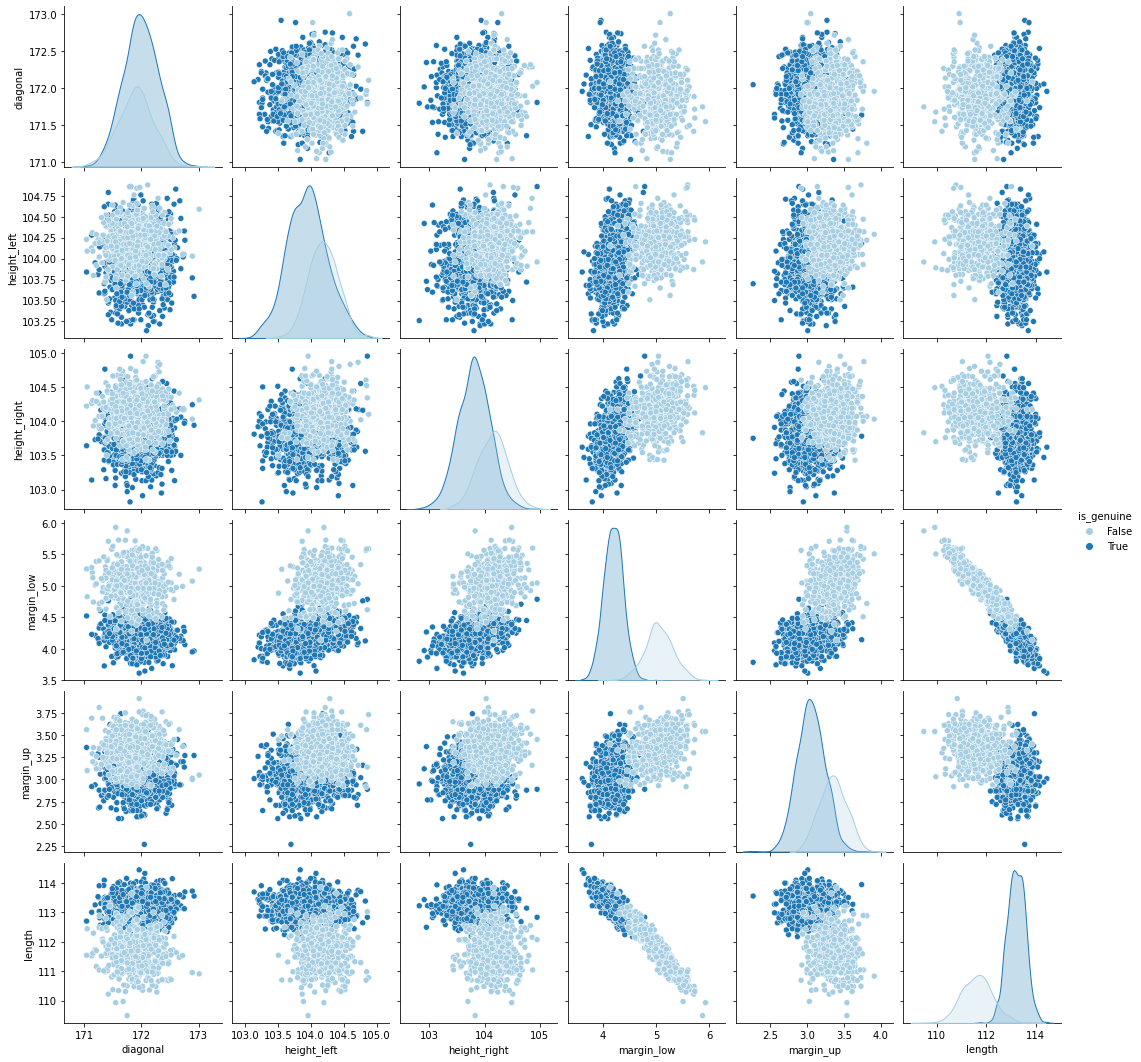

In [39]:
#Pair plot
sns.pairplot(billets, hue="is_genuine", palette="Paired")
plt.show()

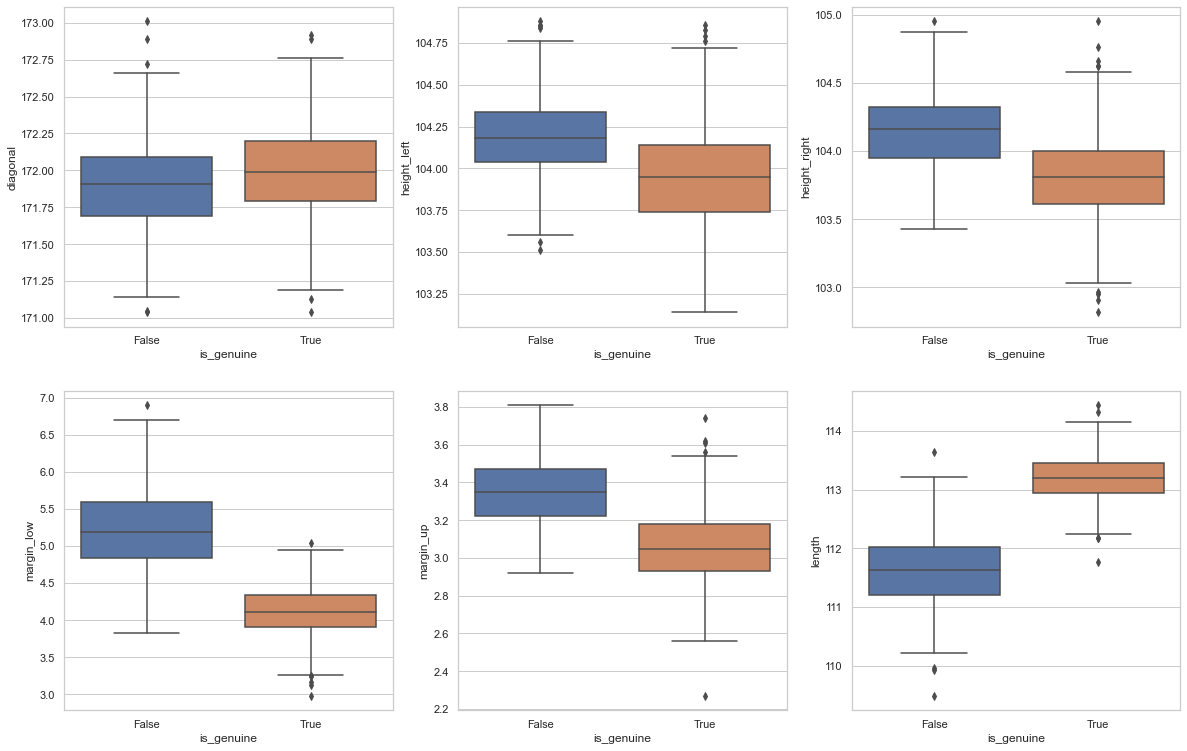

In [40]:
# Comparaison des groupes par Boxplot  sont en abscisse et les indicateurs en ordonnée
plt.figure(figsize=(20, 20))
sns.set(style="whitegrid")

plt.subplot(331)
sns.boxplot(data=billets_wihtout_indiv_atypique_influent, x='is_genuine', y='diagonal')

plt.subplot(332)
sns.boxplot(data=billets_wihtout_indiv_atypique_influent, x='is_genuine', y='height_left')

plt.subplot(333)
sns.boxplot(data=billets_wihtout_indiv_atypique_influent, x='is_genuine', y='height_right')

plt.subplot(334)
sns.boxplot(data=billets_wihtout_indiv_atypique_influent, x='is_genuine', y='margin_low')

plt.subplot(335)
sns.boxplot(data=billets_wihtout_indiv_atypique_influent, x='is_genuine', y='margin_up')

plt.subplot(336)
sns.boxplot(data=billets_wihtout_indiv_atypique_influent, x='is_genuine', y="length")

plt.show(block=False)


In [41]:
#Affichage de la matrice des corrélations
correlationMatrix = billets.corr()
correlationMatrix.round(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.00,0.13,-0.38,-0.49,-0.88,-0.61,0.85
diagonal,0.13,1.00,0.02,-0.02,-0.16,-0.06,0.10
height_left,-0.38,0.02,1.00,0.24,0.44,0.25,-0.32
height_right,-0.49,-0.02,0.24,1.00,0.57,0.31,-0.40
margin_low,-0.88,-0.16,0.44,0.57,1.00,0.62,-0.96
margin_up,-0.61,-0.06,0.25,0.31,0.62,1.00,-0.52
length,0.85,0.10,-0.32,-0.40,-0.96,-0.52,1.00


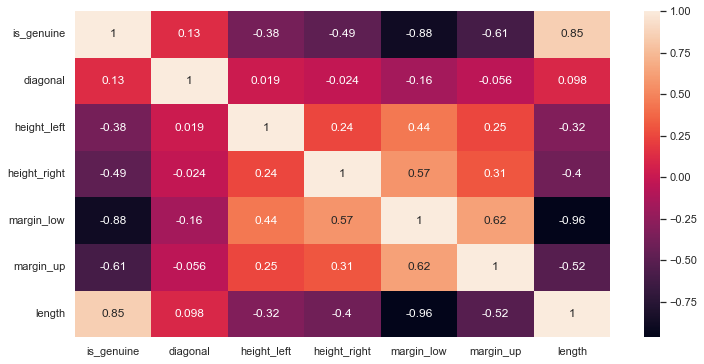

In [42]:
#Affichage d'une heatmap
plt.figure(figsize=(12,6))
sns.heatmap(correlationMatrix, annot=True)
plt.show()

## <a name="C3">VI - Analyse en composantes principales (ACP)

In [44]:
#Préparation des données pour le Clustering
names = (billets[["diagonal","height_left","height_right","margin_low","margin_up","length"]]).values
features = (billets[["diagonal","height_left","height_right","margin_low","margin_up","length"]]).columns

In [45]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(names)
X_scaled = std_scale.transform(names)

In [46]:
#On travaille sur nos 6 premiere composantes
n_components = 6
#instancie notre ACP & entraine sur les données scalées
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=6)

In [47]:
#La variance captée par chaque nouvelle composante
pca.explained_variance_ratio_

array([4.95375671e-01, 1.69574122e-01, 1.30073540e-01, 1.18112558e-01,
       8.68641089e-02, 1.91746411e-30])

In [48]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([49.54, 16.96, 13.01, 11.81,  8.69,  0.  ])

In [49]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 50.,  66.,  80.,  91., 100., 100.])

In [50]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree, edgecolor="grey")
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=True)

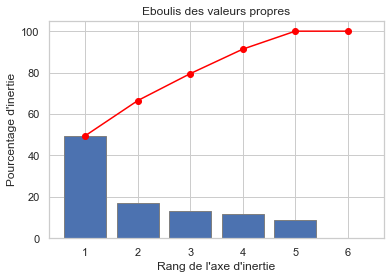

In [51]:
display_scree_plot(pca)

In [52]:
def display_circles(pcs, n_components, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_components:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(8,7))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="blue")
                
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color="black"))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center',rotation=label_rotation, color="black", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor="black")
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='black', ls='--')
            plt.plot([0, 0], [-1, 1], color='black', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        

In [53]:
# enlevé le F5 et 6, mettre au propre, utilise soit random forest ou KNM

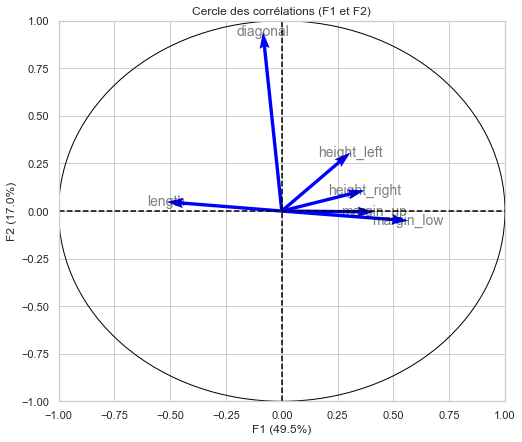

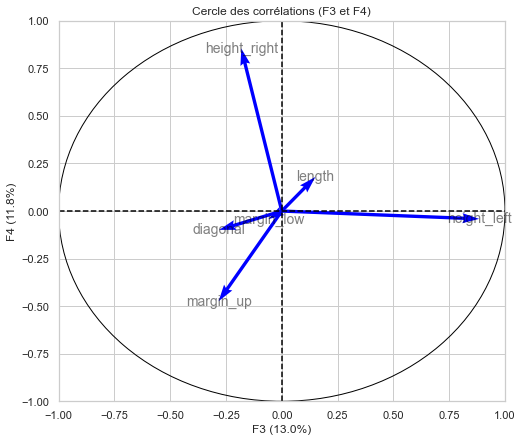

In [54]:
# Visualisation du cercle des correlations
pcs = pca.components_
display_circles(pcs, n_components, pca, [(0,1),(2,3)], labels = np.array(features))

On separe les datasets en un jeu d'entrainement et de test,notre jeu de test comportera 20% des datasets pour notre traitement.

In [57]:
X = billets.loc[:, billets.columns != "is_genuine"]
Y = billets.loc[:, billets.columns == "is_genuine"]

In [58]:
#Séparer df_billets en training set et testing set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20)

In [59]:
std_scale = preprocessing.StandardScaler().fit(X_train)
std_scale = preprocessing.StandardScaler().fit(X_test)

In [60]:
X_train.shape

(1200, 6)

In [61]:
X_test.shape

(300, 6)

## <a name="C3">VII - METHODE DES K-MEANS

C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


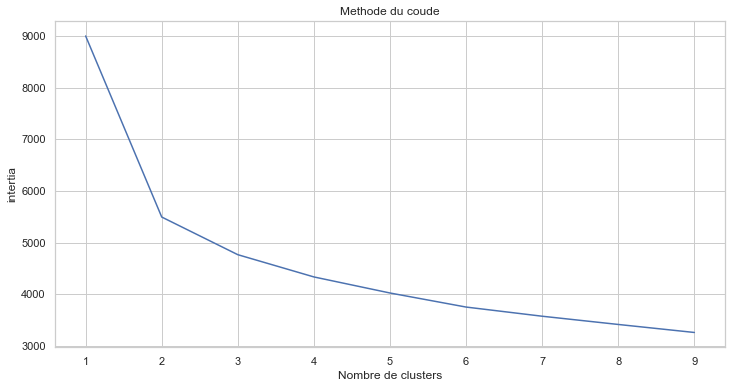

In [62]:
intertia = []

k_list = range(1, 10)
list(k_list)

for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X_scaled) 
  intertia.append(kmeans.inertia_)

fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("Nombre de clusters")
ax = plt.plot(k_list, intertia),plt.title('Methode du coude')

In [63]:
model_km = KMeans(n_clusters=2)
km=model_km.fit(X_scaled)
km.predict(X_scaled)
h=km.predict(X_scaled)
a = 1-h
print('Inertie totale :',kmeans.inertia_)

Inertie totale : 3261.3627810760167


In [95]:
#On applique le modèle aux données de l'ensemble de test et stocker les prédictions obtenues dans la variable y_pred.
#y_predict = km.fit_predict(X_test)
y_predict = km.fit_predict(X_scaled)

Text(0.5, 1.0, 'Matrice de confusion du kmeans')

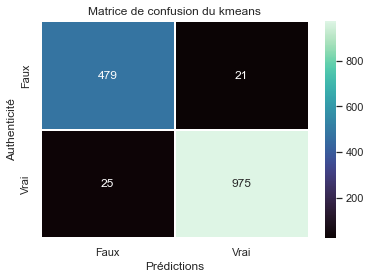

In [96]:
#metrics.confusion_matrix(Y_test, y_predict)
metrics.confusion_matrix(Y, y_predict)
#Graphique
sns.heatmap(metrics.confusion_matrix(Y, y_predict),
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"])
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion du kmeans")

Sur les 1000 vrais billets il y en a 25 qui sont des faux positifs, 
Sur les 500 faux billets, il y en a 21 qui sont des faux négatifs, 


Le recall (rappel) nous permet ici de minimiser les faux négatifs c’est-à-dire   d’éviter de dire que notre billet était faux alors qu’il s’agit d’un vrai. 

La précision nous permet de minimiser les faux positifs, c’est lorsque l’algorithme a prédit vrai billet alors que c’est un faux



In [98]:
print("Accuracy Score: ", accuracy_score(Y, y_predict))
print("Precision Score: ", precision_score(Y, y_predict))
print("Recall Score: ", recall_score(Y, y_predict))
print("Score F1: ", f1_score(Y, y_predict))

Accuracy Score:  0.9693333333333334
Precision Score:  0.9789156626506024
Recall Score:  0.975
Score F1:  0.9769539078156313


In [67]:
score_km = [("Accuracy Score: ", accuracy_score(Y_test, y_predict)),("Score F1: ", f1_score(Y_test, y_predict))]
print(score_km)

[('Accuracy Score: ', 0.9733333333333334), ('Score F1: ', 0.9803921568627451)]


In [68]:
print(classification_report(Y_test, y_predict))

              precision    recall  f1-score   support

       False       1.00      0.92      0.96       100
        True       0.96      1.00      0.98       200

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



## <a name="C3">VIII -  Régression logistique

In [69]:
model_logit = LogisticRegression()
model_logit.fit(X_train, Y_train)

C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [70]:
# Coefficients
pd.DataFrame(np.concatenate([model_logit.intercept_.reshape(-1, 1), model_logit.coef_], axis=1), index=["coef"], columns=["constante"]+list(X.columns))


,constante,diagonal,height_left,height_right,margin_low,margin_up,length
coef,-0.027949,0.192526,-1.608643,-2.127705,-3.405348,-3.228007,3.3936


In [71]:
y_pred_test = model_logit.predict(X_test)

Text(0.5, 1.0, 'Matrice de confusion de la régression logistique')

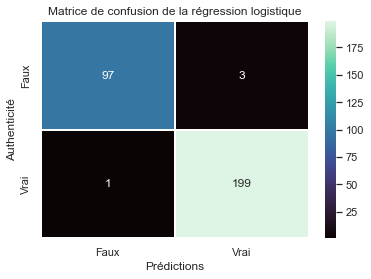

In [72]:
metrics.confusion_matrix(Y_test, y_pred_test)

#Graphique
sns.heatmap(metrics.confusion_matrix(Y_test, y_pred_test),
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"])
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique")



In [74]:
accuracy = accuracy_score(Y_test, y_pred_test)
print("Le taux de prédiction correcte sur toutes les données de test = {}%".format( round(accuracy, 4)))

Le taux de prédiction correcte sur toutes les données de test = 0.9867%


In [75]:
print('R2 de Train_score:', round(model_logit.score(X_train,Y_train),3))
print('R2 de Test_score:', round(model_logit.score(X_test,Y_test),3))

R2 de Train_score: 0.971
R2 de Test_score: 0.987


In [76]:
print("Accuracy Score: ", accuracy_score(Y_test, y_pred_test))
print("Precision Score: ", precision_score(Y_test, y_pred_test))
print("Recall Score: ", recall_score(Y_test, y_pred_test))
print("Score F1: ", f1_score(Y_test, y_pred_test))



Accuracy Score:  0.9866666666666667
Precision Score:  0.9851485148514851
Recall Score:  0.995
Score F1:  0.9900497512437811


In [77]:
score_reg_log = [("Accuracy Score: ", accuracy_score(Y_test, y_pred_test)),("Score F1: ", f1_score(Y_test, y_pred_test))]
print(score_reg_log)

[('Accuracy Score: ', 0.9866666666666667), ('Score F1: ', 0.9900497512437811)]


In [78]:
print(classification_report(Y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



## <a name="C3">IX -  (k-NN) KNEIGHORS CLASSIFIER


In [79]:
#on centre et reduit les variables explicatives des deux echantillons
X_train_scaled = preprocessing.scale(X_train)
Y_train_scaled = preprocessing.scale(Y_train)

In [80]:
score = []


for k in range(2, 50):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    score.append(knn.score(X_test, Y_test.values.ravel())) 

#on affiche les scores
print(score)

#le meilleur score est le 1 avec 0,99%  


C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was 

[0.9533333333333334, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.98, 0.9766666666666667, 0.98, 0.9833333333333333, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9833333333333333, 0.9866666666666667, 0.99, 0.99, 0.99, 0.99, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9833333333333333, 0.9866666666666667, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9866666666666667, 0.9866666666666667, 0.9866666666666667, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333, 0.9833333333333333]


C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was 

In [109]:
#Création du classificateur et entraînement du modèle
knn_m = neighbors.KNeighborsClassifier(n_neighbors=2)
knn_m.fit(X_train, Y_train)

C:\Users\louna.chrisostome\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=2)

In [110]:
#On applique le modèle aux données de l'ensemble de test et stocker les prédictions obtenues dans la variable y_pred.
y_pred = knn.predict(X_test)

Text(0.5, 1.0, 'Matrice de confusion kNN')

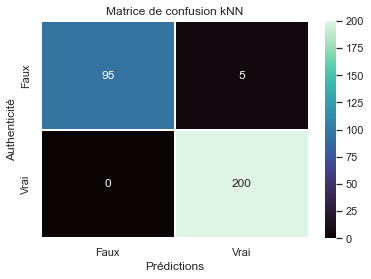

In [111]:
metrics.confusion_matrix(Y_test, y_pred)

#Graphique
sns.heatmap(metrics.confusion_matrix(Y_test, y_pred),
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("mako", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"])
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion kNN")

In [112]:
print("Accuracy Score: ", accuracy_score(Y_test, y_pred))
print("Precision Score: ", precision_score(Y_test, y_pred))
print("Recall Score: ", recall_score(Y_test, y_pred))
print("Score F1: ", f1_score(Y_test, y_pred))


Accuracy Score:  0.9833333333333333
Precision Score:  0.975609756097561
Recall Score:  1.0
Score F1:  0.9876543209876543


In [85]:
score_knn = [("Accuracy Score: ", accuracy_score(Y_test, y_pred)),("Score F1: ", f1_score(Y_test, y_pred))]
print(score_knn)

[('Accuracy Score: ', 0.9833333333333333), ('Score F1: ', 0.9876543209876543)]


In [86]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      0.95      0.97       100
        True       0.98      1.00      0.99       200

    accuracy                           0.98       300
   macro avg       0.99      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300



## <a name="C3">X -  Conclusion

In [88]:
score_reg_log = [("Precision Score: ", precision_score(Y_test, y_pred_test)),("Recall Score: ", recall_score(Y_test, y_pred_test))]
print(score_reg_log)
score_km = [("Precision Score: ", precision_score(Y_test, y_predict)),("Recall Score: ", recall_score(Y_test, y_predict))]
print(score_km)
score_knn = [("Precision Score: ", precision_score(Y_test, y_pred)),("Recall Score: ", recall_score(Y_test, y_pred))]
print(score_knn)

[('Precision Score: ', 0.9851485148514851), ('Recall Score: ', 0.995)]
[('Precision Score: ', 0.9615384615384616), ('Recall Score: ', 1.0)]
[('Precision Score: ', 0.975609756097561), ('Recall Score: ', 1.0)]


Le recall (rappel) nous permet ici de minimiser les faux négatifs c’est-à-dire   d’éviter de dire que notre billet était faux alors qu’il s’agit d’un vrai. 

La précision nous permet de minimiser les faux positifs, c’est lorsque l’algorithme a prédit vrai billet alors que c’est un faux


## <a name="C3">XI - Test d'application du modèle  

In [89]:
billets_production = pd.read_csv("billets_test.csv")
billets_production.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [90]:
billets_production_values=billets_production.drop('id', axis=1)
billets_production_values

,diagonal,height_left,height_right,margin_low,margin_up,length
0,172.09,103.95,103.73,4.39,3.09,113.19
1,171.52,104.17,104.03,5.27,3.16,111.82
2,171.78,103.80,103.75,3.81,3.24,113.39
3,172.02,104.08,103.99,5.57,3.30,111.10
4,171.79,104.34,104.37,5.00,3.07,111.87


In [91]:
y_pred_production = model_logit.predict(billets_production_values)
y_pred_production


array([ True, False,  True, False, False])

In [92]:
proba_true = model_logit.predict_proba(billets_production_values)[:, 1]
proba_true

array([9.87582933e-01, 9.97484734e-03, 9.98751881e-01, 2.77771889e-04,
       1.53234947e-02])

In [93]:
billets_production['Prediction'] = y_pred_production
billets_production['Probability_is_true'] = proba_true.round(3)
billets_production

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Prediction,Probability_is_true
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True,0.988
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False,0.010
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True,0.999
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False,0.000
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False,0.015


In [94]:
billets_production_prediction = billets_production[['id','Prediction','Probability_is_true']].set_index("id")
billets_production_prediction 

,Prediction,Probability_is_true
id,,
B_1,True,0.988
B_2,False,0.010
B_3,True,0.999
B_4,False,0.000
B_5,False,0.015


Les variables les plus corrélées à F1 et F2 sont :

Margin_low
Margin_up
Height_right
Length
Les variables les plus corrélées à F3 et F4 sont :

Diagonal